In [37]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

## Config

In [38]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Formatting Model Predictions

### Channel agreement functions

In [39]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','ueo_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

### Channel level

In [40]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]
# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]
# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
annotations_df.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 120,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

# pred_channels_wdice.to_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))
# pred_channels_wkappa.to_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))

### Region level

In [41]:
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()

In [42]:
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique() if l != 'EmptyLabel'])
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals

In [43]:
predicted_channels[['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head(12)

,Patient,iEEG_ID,model,threshold,ueo_rs_strict
724,HUP229,HUP229_phaseII,LSTM,0.50,"[ left amygdala , left hippocampus , left in..."
736,HUP229,HUP229_phaseII,AbsSlp,0.05,"[ left amygdala , left superior temporal , l..."
735,HUP229,HUP229_phaseII,AbsSlp,0.00,"[ left amygdala , left superior temporal , l..."
734,HUP229,HUP229_phaseII,LSTM,1.00,[]
733,HUP229,HUP229_phaseII,LSTM,0.95,"[ left hippocampus , left parahippocampal ]"
732,HUP229,HUP229_phaseII,LSTM,0.90,"[ left hippocampus , left parahippocampal ]"
731,HUP229,HUP229_phaseII,LSTM,0.85,"[ left amygdala , left hippocampus , left pa..."
730,HUP229,HUP229_phaseII,LSTM,0.80,"[ left amygdala , left hippocampus , left pa..."
729,HUP229,HUP229_phaseII,LSTM,0.75,"[ left amygdala , left hippocampus , left in..."
728,HUP229,HUP229_phaseII,LSTM,0.70,"[ left amygdala , left hippocampus , left in..."


In [44]:
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                        annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                        on='approximate_onset',by='Patient',
                                        tolerance = 120,
                                        direction='nearest')
pred_regions_wannots.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)

In [45]:
pred_regions_wannots

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
651,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
630,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
650,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
671,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
649,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,0.90,"[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...","[R01, R02, RB04, RB05]","[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...",...,1.0,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , EmptyLabel, rig...","[ right cerebellum exterior , right fusiform ]","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v.

In [46]:
def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','ueo_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row
pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

In [47]:
pred_regions_wkappa.to_pickle(ospj(prodatapath,'predicted_regions_wkappa.pkl'))

## Channel Agreement Optimization

### DICE

In [48]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
mdl_preds_sorted.head()
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [49]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.727273,0.571429,"[LB01, LB02, LB03, LC01, LC02]",0.312500,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.666667,0.578947,ueo_consensus_strict_dice,0.687500
2,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
3,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.727273,0.571429,"[LB01, LB02, LB03, LC01, LC02]",0.312500,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.666667,0.578947,ueo_consensus_strict_dice,0.687500
4,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.143713,0.127660,"[LB01, LB02, LB03, LC01, LC02]",0.055249,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.133333,0.117647,ueo_consensus_strict_dice,0.132530


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

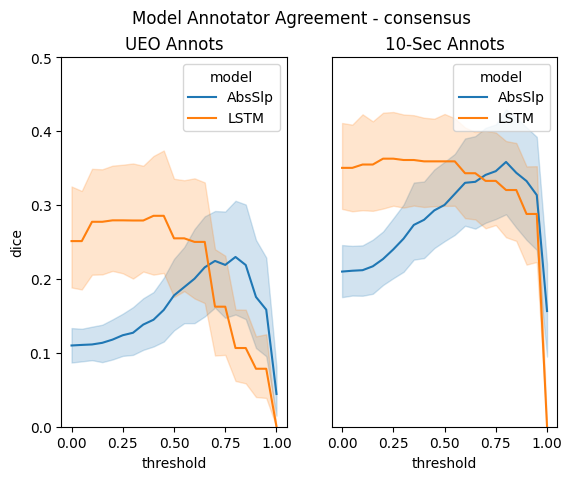

In [50]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Kappa

In [63]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
# mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [64]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_strict' 'sec_chs_strict_any_kappa'
 'sec_chs_strict_bool' 'sec_chs_strict_consensus_kappa' 'sec_consensus'
 'stim' 'threshold' 'to_annotate' 'ueo_any' 'ueo_chs_loose'
 'ueo_chs_loose_any_kappa' 'ueo_chs_loose_bool'
 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_any,ueo_chs_strict_bool,ueo_chs_strict_any_kappa,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.049912,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,ueo_chs_strict_consensus_kappa,0.045643
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, False, False, False, ...",0.707875,"[True, True, True, True, True, False, False, F...",0.501710,0.536913,"[True, True, True, True, False, False, False, ...",0.645171,ueo_chs_strict_consensus_kappa,0.666570
2,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.049912,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,ueo_chs_strict_consensus_kappa,0.045643
3,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, False, False, False, ...",0.707875,"[True, True, True, True, True, False, False, F...",0.501710,0.536913,"[True, True, True, True, False, False, False, ...",0.645171,ueo_chs_strict_consensus_kappa,0.666570
4,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.051888,"[True, True, True, True, True, True, True, Tru...",0.030354,0.033217,"[True, True, True, True, True, True, True, Tru...",0.048377,ueo_chs_strict_consensus_kappa,0.047455


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

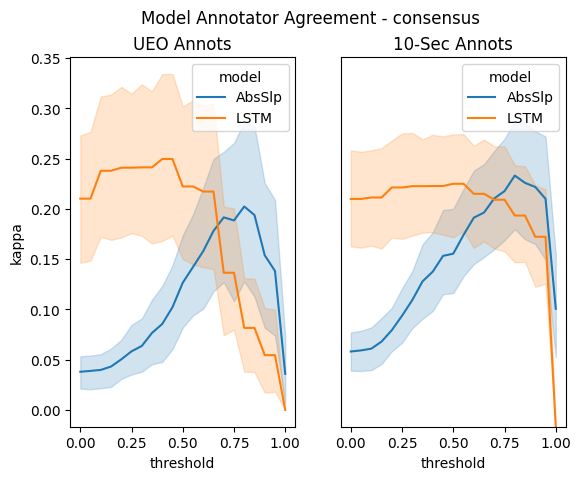

In [66]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
# axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Getting optimal threshold

In [54]:
mask = mdl_preds_sorted.model == 'LSTM'
print(mdl_preds.columns)
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_chs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_chs_strict_consensus_kappa'].mean()

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_chs_strict_bool', 'ueo_chs_strict_consensus_kappa',
       'ueo_chs_strict_any_kappa', 'ueo_chs_loose_bool',
       'ueo_chs_loose_consensus_kappa', 'ueo_chs_loose_any_kappa',
       'sec_chs_strict_bool', 'sec_chs_strict_consensus_kappa',
       'sec_chs_strict_any_kappa'],
      dtype='object')


In [55]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])

0.4
0.5


## Region Agreement Optimization

### Kappa

In [71]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_regions_wkappa.pkl"))
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [72]:
melt_cols = [f'ueo_rs_{mdl_anntype}_{anntype}_kappa',f'sec_rs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.005277,ueo_rs_strict_consensus_kappa,0.005277
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]",0.442308,0.442308,0.442308,0.524590,ueo_rs_strict_consensus_kappa,0.442308
2,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.005277,ueo_rs_strict_consensus_kappa,0.005277
3,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]",0.524590,0.524590,0.524590,0.524590,ueo_rs_strict_consensus_kappa,0.524590
4,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.005277,ueo_rs_strict_consensus_kappa,0.005277


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

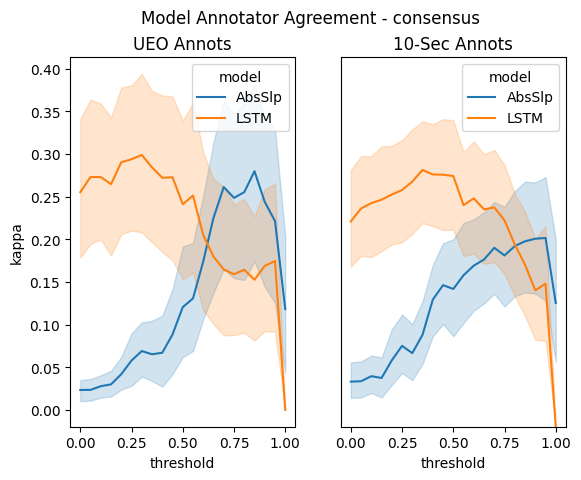

In [77]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
# axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((0,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

In [75]:
mask = mdl_preds_sorted.model == 'LSTM'
print(mdl_preds.columns)
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_rs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_rs_strict_consensus_kappa'].mean()

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'ueo_rs_strict',
       'ueo_rs_loose', 'sec_rs_strict', 'sec_rs_loose', 'all_rs',
       'ueo_consensus_rs', 'ueo_any_rs', 'sec_consensus_rs', 'sec_any_rs',
       'ueo_rs_strict_consensus_kappa', 'ueo_rs_strict_any_kappa',
       'ueo_rs_loose_consensus_kappa', 'ueo_rs_loose_any_kappa',
       'sec_rs_strict_consensus_kappa', 'sec_rs_strict_any_kappa'],
      dtype='object')


### Getting optimal threshold

In [76]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])

0.30000000000000004
0.35000000000000003
